# SAMSum Dialogue Summarization


## Executive Summary
This notebook provides a **complete data quality pipeline** for the SAMSum dataset to maximize model accuracy, robustness, and generalization for fine-tuning transformer-based summarization models (T5, BART, PEGASUS).

---



## 1. DATASET UNDERSTANDING



### SAMSum Structure
- **Source**: Samsung corpus of messenger-like conversations
- **Format**: Multi-turn dialogues with extractive-abstractive summaries
- **Columns**: `id`, `dialogue`, `summary`

### Core Characteristics
1. **Dialogue Format**:
   - Speaker-attributed turns: `Name: utterance\n`
   - Informal, chat-like language (emojis, slang, abbreviations)
   - 2-7 speakers typical (but varies)
   
2. **Summary Characteristics**:
   - Abstractive (paraphrased, not extractive quotes)
   - Third-person narrative style
   - Captures: who, what, when, action items
   
3. **Known Weaknesses**:
   - Inconsistent speaker naming (John vs john vs J)
   - Variable dialogue lengths (2 turns to 50+)
   - Some summaries hallucinate details
   - Noise from informal language and emojis
   - Duplicate or near-duplicate dialogues
   - Speaker-less or malformed turns


### SAMSum Structure
- **Source**: Samsung corpus of messenger-like conversations
- **Format**: Multi-turn dialogues with extractive-abstractive summaries
- **Columns**: `id`, `dialogue`, `summary`

### Core Characteristics
1. **Dialogue Format**:
   - Speaker-attributed turns: `Name: utterance\n`
   - Informal, chat-like language (emojis, slang, abbreviations)
   - 2-7 speakers typical (but varies)
   
2. **Summary Characteristics**:
   - Abstractive (paraphrased, not extractive quotes)
   - Third-person narrative style
   - Captures: who, what, when, action items
   
3. **Known Weaknesses**:
   - Inconsistent speaker naming (John vs john vs J)
   - Variable dialogue lengths (2 turns to 50+)
   - Some summaries hallucinate details
   - Noise from informal language and emojis
   - Duplicate or near-duplicate dialogues
   - Speaker-less or malformed turns

In [227]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import warnings
from collections import Counter, defaultdict
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("Libraries loaded successfully")

Libraries loaded successfully


In [228]:
# Load datasets
df = pd.read_csv("/content/samsum_train.csv")
test = pd.read_csv("/content/samsum_test.csv")

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nTrain shape: {df.shape}")
print(f"Test shape: {test.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

DATASET OVERVIEW

Train shape: (10312, 3)
Test shape: (2210, 2)

Columns: ['id', 'dialogue', 'summary']

Data types:
id          object
dialogue    object
summary     object
dtype: object

Missing values:
id          0
dialogue    1
summary     0
dtype: int64


In [229]:
# Sample dialogue
print("=" * 80)
print("SAMPLE DIALOGUE")
print("=" * 80)
print(f"\nID: {df.iloc[0]['id']}")
print(f"\nDialogue:\n{df.iloc[0]['dialogue']}")
print(f"\nSummary:\n{df.iloc[0]['summary']}")
print("\n" + "=" * 80)

SAMPLE DIALOGUE

ID: 13818399

Dialogue:
Max: How's your job hunt going?
Dorothy: Uhh, I send a hundred CVs a day
Max: a hundred?!
Dorothy: yeah I mean I don't even care if I fit the profile, I see the ad, I send my CV :D
Max: that's one way of looking at it xD
Dorothy: If even 10% of the companies call me back it's still gonna look good
Max: True
Max: Good luck!!
Dorothy: Thanks :)

Summary:
B has been looking for a job and sending a hundred CVs a day even when she doesn't meet the criteria. She hopes for a 10% response rate.



In [230]:
# Droping Null dialogue Row
df = df.dropna(subset=["dialogue"]).reset_index(drop=True)

In [231]:
df.shape

(10311, 3)

---

## 2. EXPLORATORY DATA ANALYSIS (EDA)

### Feature Extraction Functions

We'll build extraction functions to systematically analyze dialogue and summary characteristics.

In [232]:
def extract_dialogue_features(dialogue_text):
    """
    Extract comprehensive features from a dialogue.
    Correctly handles SAMSum speaker format and malformed turns.
    """
    if pd.isna(dialogue_text) or not isinstance(dialogue_text, str):
        return {
            'num_turns': 0,
            'num_speakers': 0,
            'total_words': 0,
            'avg_words_per_turn': 0,
            'speakers': [],
            'has_malformed_turns': True,
            'has_empty_turns': True,
            'speaker_pattern_consistent': False,
            'dialogue_text': ''
        }

    # SAMSum uses '\n', not '\r\n'
    turns = [t.strip() for t in dialogue_text.split('\n') if t.strip()]

    speakers = []
    turn_word_counts = []
    has_malformed = False
    has_empty_turn = False

    for turn in turns:
        # Match: SpeakerName: utterance
        match = re.match(r'^([^:]+):\s*(.*)$', turn)
        if match:
            speaker = match.group(1).strip()
            utterance = match.group(2).strip()

            # Ignore non-dialogue markers
            if speaker.startswith("<") and speaker.endswith(">"):
                has_malformed = True
                continue

            speakers.append(speaker)

            word_count = len(utterance.split())
            turn_word_counts.append(word_count)

            if word_count == 0:
                has_empty_turn = True
        else:
            has_malformed = True

    # Unique speakers (case-sensitive)
    unique_speakers = sorted(set(speakers))

    total_words = sum(turn_word_counts)
    avg_words = np.mean(turn_word_counts) if turn_word_counts else 0

    # Consistency: same speaker not written in multiple cases
    speaker_pattern_consistent = len(
        set(s.lower() for s in speakers)
    ) == len(unique_speakers)

    return {
        'num_turns': len(turns),
        'num_speakers': len(unique_speakers),
        'total_words': total_words,
        'avg_words_per_turn': avg_words,
        'speakers': unique_speakers,
        'has_malformed_turns': has_malformed,
        'has_empty_turns': has_empty_turn,
        'speaker_pattern_consistent': speaker_pattern_consistent,
        'dialogue_text': dialogue_text
    }


In [233]:
def extract_summary_features(summary_text):
    """
    Extract summary characteristics.
    """
    if pd.isna(summary_text) or not isinstance(summary_text, str):
        return {
            'summary_length': 0,
            'summary_words': 0,
            'is_empty': True
        }

    words = summary_text.split()
    return {
        'summary_length': len(summary_text),
        'summary_words': len(words),
        'is_empty': len(words) == 0
    }


In [234]:
df.shape

(10311, 3)

In [235]:
# Extract features for all dialogues
print("Extracting features from training set...")
dialogue_features = df['dialogue'].apply(extract_dialogue_features)
summary_features = df['summary'].apply(extract_summary_features)

# Convert to DataFrames
dialogue_df = pd.DataFrame(dialogue_features.tolist())
summary_df = pd.DataFrame(summary_features.tolist())

# Merge with original dataframe
df_analysis = pd.concat([df, dialogue_df, summary_df], axis=1)

# Calculate compression ratio
df_analysis['compression_ratio'] = df_analysis['total_words'] / (df_analysis['summary_words'] + 1e-6)

print("✓ Feature extraction complete")
print(f"\nAnalysis dataframe shape: {df_analysis.shape}")

Extracting features from training set...
✓ Feature extraction complete

Analysis dataframe shape: (10311, 16)


### 2.1 Dialogue Statistics

In [236]:
# 2.1 Dialogue Statistics
print("=" * 80)
print("DIALOGUE STATISTICS")
print("=" * 80)

stats_cols = ['num_turns', 'num_speakers', 'total_words', 'avg_words_per_turn']

dialogue_stats = df_analysis[stats_cols].describe(percentiles=[.01, .05, .25, .50, .75, .85, .95, .99])
print("\n", dialogue_stats.round(2))

# Identify outliers
print("\n" + "=" * 80)
print("OUTLIER DETECTION (> 95th percentile)")
print("=" * 80)

for col in stats_cols:
    p95 = df_analysis[col].quantile(0.95)
    outliers = df_analysis[df_analysis[col] > p95]
    print(f"\n{col}:")
    print(f"  95th percentile: {p95:.1f}")
    print(f"  Outliers: {len(outliers)} samples")
    print(f"  Max value: {df_analysis[col].max():.1f}")


DIALOGUE STATISTICS

        num_turns  num_speakers  total_words  avg_words_per_turn
count   10311.00      10311.00     10311.00            10311.00
mean       11.14          2.40        82.42                7.02
std         6.40          0.83        68.86                3.37
min         3.00          2.00         4.00                1.00
1%          3.00          2.00         9.00                2.15
5%          3.00          2.00        14.00                3.11
25%         6.00          2.00        33.00                4.77
50%        10.00          2.00        63.00                6.33
75%        15.00          3.00       111.00                8.45
85%        19.00          3.00       144.00                9.89
95%        23.00          4.00       216.50               13.25
99%        29.00          6.00       329.00               18.59
max        31.00         14.00       615.00               53.14

OUTLIER DETECTION (> 95th percentile)

num_turns:
  95th percentile: 23.0
  Outli

In [237]:
# Number of speakers
print("\n" + "=" * 80)
print("NUM_SPEAKERS DISTRIBUTION")
print("=" * 80)

print(
    df_analysis["num_speakers"]
    .value_counts()
    .sort_index()
)


# Number of turns
print("\n" + "=" * 80)
print("NUM_TURNS DISTRIBUTION")
print("=" * 80)

print(
    df_analysis["num_turns"]
    .value_counts()
    .sort_index()
)



NUM_SPEAKERS DISTRIBUTION
num_speakers
2     7533
3     1966
4      566
5      141
6       51
7       21
8       11
9       11
10       5
11       3
13       2
14       1
Name: count, dtype: int64

NUM_TURNS DISTRIBUTION
num_turns
3     593
4     895
5     832
6     918
7     599
8     691
9     580
10    475
11    375
12    409
13    507
14    529
15    409
16    350
17    300
18    271
19    293
20    303
21    185
22    170
23    113
24    138
25     87
26     67
27     50
28     66
29     42
30     62
31      2
Name: count, dtype: int64


In [238]:
# Filter rows with exactly 1 speaker
single_speaker_df = df_analysis[df_analysis["num_turns"] == 31]

# Sample up to 5 examples (safe if fewer than 5 exist)
samples = single_speaker_df.sample(
    n=min(5, len(single_speaker_df)),
    random_state=42
)

# Display dialogue + summary
for i, row in samples.iterrows():
    print("=" * 80)
    print("DIALOGUE")
    print("-" * 80)
    print(row["dialogue"])
    print("\nSUMMARY")
    print("-" * 80)
    print(row["summary"])


DIALOGUE
--------------------------------------------------------------------------------
Pete: Morning Thomas, the video file is too big. I need to blue tooth it to my laptop first.
Thomas: Why don't you put it on a memory stick for me?
Pete: That's what mean.
Thomas: ???
Pete: It's too big to be sent from my mobile to yours. Directly I mean.
Thomas: So from your smartphone to your laptop to a memory stick?
Pete: Ya.
Thomas: A bit complicated. And could you blue tooth it straight to my laptop?
Pete: I should think so.
Thomas: Has my laptop got blue tooth?
Pete: How can I know?!
Thomas: Wait a sec. How do I check it?
Pete: Don't be ridiculous! Any good laptop has blue tooth connectivity! What have you got?
Thomas: Toshiba ultrabook Satellite something.
Pete: As good as it gets.
Thomas: When could I pop in to fix it?
Pete: Any time really. I'm alone till 6:30 pm.
Thomas: Too bad. Can't today.
Pete: But I can also upload the file to my dropbox and share it with you.
Thomas: What's dropbo

In [239]:
#Total words (dialogue length buckets)
print("\n" + "=" * 80)
print("TOTAL_WORDS DISTRIBUTION (BIN SIZE = 25)")
print("=" * 80)

max_words = int(df_analysis["total_words"].max())
bins_words = list(range(0, max_words + 20, 20))

total_words_dist = (
    pd.cut(df_analysis["total_words"], bins=bins_words, right=False)
    .value_counts()
    .sort_index()
)

print(total_words_dist)


# Average words per turn
print("\n" + "=" * 80)
print("AVG_WORDS_PER_TURN DISTRIBUTION (BINS)")
print("=" * 80)

bins_avg = [0, 5, 10, 20, 30, 50, float("inf")]

avg_words_dist = (
    pd.cut(df_analysis["avg_words_per_turn"], bins=bins_avg)
    .value_counts()
    .sort_index()
)

print(avg_words_dist)



TOTAL_WORDS DISTRIBUTION (BIN SIZE = 25)
total_words
[0, 20)       1094
[20, 40)      2120
[40, 60)      1728
[60, 80)      1283
[80, 100)     1019
[100, 120)     814
[120, 140)     590
[140, 160)     433
[160, 180)     334
[180, 200)     232
[200, 220)     173
[220, 240)     119
[240, 260)      99
[260, 280)      61
[280, 300)      58
[300, 320)      32
[320, 340)      29
[340, 360)      20
[360, 380)      26
[380, 400)       7
[400, 420)      11
[420, 440)       8
[440, 460)       5
[460, 480)       1
[480, 500)       4
[500, 520)       4
[520, 540)       2
[540, 560)       0
[560, 580)       0
[580, 600)       2
[600, 620)       3
Name: count, dtype: int64

AVG_WORDS_PER_TURN DISTRIBUTION (BINS)
avg_words_per_turn
(0.0, 5.0]      3054
(5.0, 10.0]     5789
(10.0, 20.0]    1399
(20.0, 30.0]      62
(30.0, 50.0]       6
(50.0, inf]        1
Name: count, dtype: int64


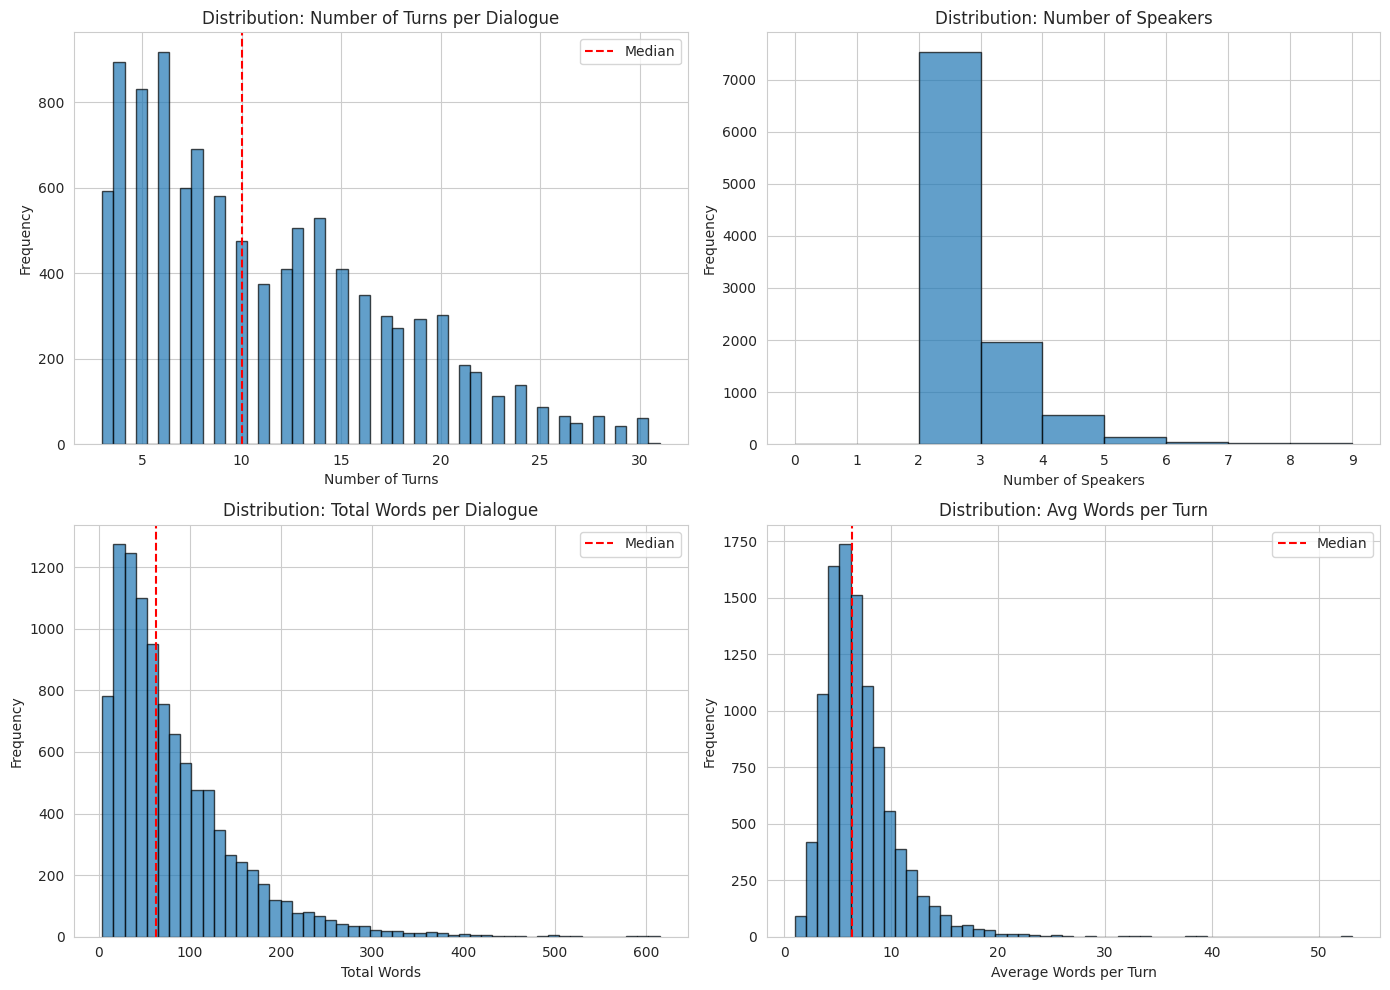

In [240]:
# Visualizations for dialogue statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Number of turns
axes[0, 0].hist(df_analysis['num_turns'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_analysis['num_turns'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].set_xlabel('Number of Turns')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution: Number of Turns per Dialogue')
axes[0, 0].legend()

# Number of speakers
axes[0, 1].hist(df_analysis['num_speakers'], bins=range(0, 10), edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Speakers')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution: Number of Speakers')
axes[0, 1].set_xticks(range(0, 10))

# Total words
axes[1, 0].hist(df_analysis['total_words'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df_analysis['total_words'].median(), color='red', linestyle='--', label='Median')
axes[1, 0].set_xlabel('Total Words')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution: Total Words per Dialogue')
axes[1, 0].legend()

# Average words per turn
axes[1, 1].hist(df_analysis['avg_words_per_turn'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df_analysis['avg_words_per_turn'].median(), color='red', linestyle='--', label='Median')
axes[1, 1].set_xlabel('Average Words per Turn')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution: Avg Words per Turn')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 2.2 Summary Statistics

In [241]:
# 2.2 Summary Statistics
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

summary_stats_cols = ['summary_words', 'compression_ratio']
summary_stats = df_analysis[summary_stats_cols].describe(percentiles=[.01, .05, .1, .25, .50, .75, .95, .99])
print("\n", summary_stats.round(2))

# Identify problematic summaries
print("\n" + "=" * 80)
print("SUMMARY QUALITY FLAGS")
print("=" * 80)

# Too short summaries (likely low quality)
too_short = df_analysis[df_analysis['summary_words'] < 5]
print(f"\nSummaries with <5 words: {len(too_short)}")
if len(too_short) > 0:
    print("Examples:")
    for idx, row in too_short.head(3).iterrows():
        print(f"  - '{row['summary']}'")

# Too long summaries (may be over-detailed or extractive)
too_long = df_analysis[df_analysis['summary_words'] > df_analysis['summary_words'].quantile(0.99)]
print(f"\nSummaries >99th percentile ({df_analysis['summary_words'].quantile(0.99):.0f} words): {len(too_long)}")

# Very low compression (summary nearly as long as dialogue - likely extractive)
low_compression = df_analysis[df_analysis['compression_ratio'] < 2]
print(f"\nLow compression ratio (<2): {len(low_compression)}")
print(f"  These summaries are >50% the length of the dialogue (likely extractive)")

# Very high compression (may miss important details)
high_compression = df_analysis[df_analysis['compression_ratio'] > df_analysis['compression_ratio'].quantile(0.99)]
print(f"\nHigh compression ratio (>99th %ile): {len(high_compression)}")
print(f"  Max compression: {df_analysis['compression_ratio'].max():.1f}x")

SUMMARY STATISTICS

        summary_words  compression_ratio
count       10311.00           10311.00
mean           20.39               4.18
std            11.24               3.17
min             1.00               0.29
1%              4.00               0.89
5%              7.00               1.27
10%             8.00               1.56
25%            12.00               2.22
50%            18.00               3.33
75%            27.00               5.07
95%            43.00               9.80
99%            53.00              16.23
max            60.00              57.00

SUMMARY QUALITY FLAGS

Summaries with <5 words: 117
Examples:
  - 'B has a birthday.'
  - 'A's dating Sarah again.'
  - 'A will be late.'

Summaries >99th percentile (53 words): 85

Low compression ratio (<2): 2111
  These summaries are >50% the length of the dialogue (likely extractive)

High compression ratio (>99th %ile): 104
  Max compression: 57.0x


In [242]:
print("\n" + "=" * 80)
print("SUMMARY_WORDS DISTRIBUTION (BINS)")
print("=" * 80)

bins_summary = [0, 5, 10, 15, 20, 30, 40, 60, 100, float("inf")]

summary_words_dist = (
    pd.cut(df_analysis["summary_words"], bins=bins_summary, right=False)
    .value_counts()
    .sort_index()
)

print(summary_words_dist)



SUMMARY_WORDS DISTRIBUTION (BINS)
summary_words
[0.0, 5.0)        117
[5.0, 10.0)      1416
[10.0, 15.0)     2288
[15.0, 20.0)     1921
[20.0, 30.0)     2554
[30.0, 40.0)     1232
[40.0, 60.0)      777
[60.0, 100.0)       6
[100.0, inf)        0
Name: count, dtype: int64


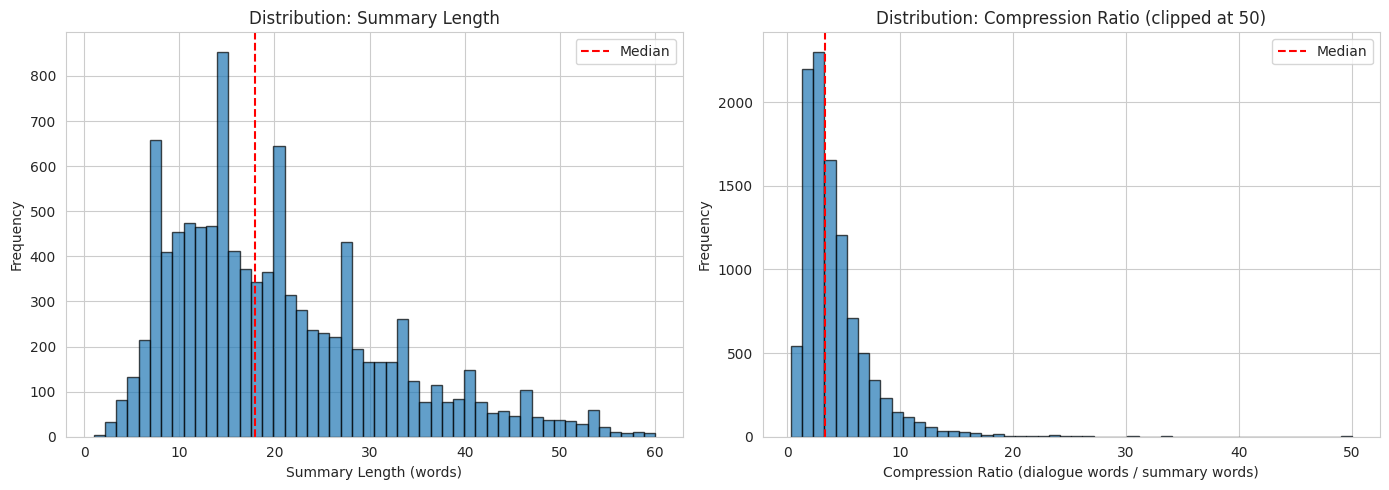

In [243]:
# Visualizations for summary statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Summary length distribution
axes[0].hist(df_analysis['summary_words'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_analysis['summary_words'].median(), color='red', linestyle='--', label='Median')
axes[0].set_xlabel('Summary Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution: Summary Length')
axes[0].legend()

# Compression ratio distribution
axes[1].hist(df_analysis['compression_ratio'].clip(upper=50), bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(df_analysis['compression_ratio'].median(), color='red', linestyle='--', label='Median')
axes[1].set_xlabel('Compression Ratio (dialogue words / summary words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution: Compression Ratio (clipped at 50)')
axes[1].legend()

plt.tight_layout()
plt.show()

### 2.3 Speaker Behavior Analysis

In [244]:
# 2.3 Speaker Behavior Analysis
print("=" * 80)
print("SPEAKER BEHAVIOR ANALYSIS")
print("=" * 80)

# Analyze speaker inconsistencies
inconsistent_speakers = df_analysis[~df_analysis['speaker_pattern_consistent']]
print(f"\nDialogues with inconsistent speaker naming: {len(inconsistent_speakers)}")
print(f"  (e.g., 'John' vs 'john' vs 'JOHN')")

# Malformed turns
malformed = df_analysis[df_analysis['has_malformed_turns']]
print(f"\nDialogues with malformed turns: {len(malformed)}")
print(f"  (missing speaker tags or improper format)")

# Empty utterances
empty_utterances = df_analysis[df_analysis['has_empty_turns']]
print(f"\nDialogues with empty utterances: {len(empty_utterances)}")
print(f"  (speaker tag present but no text)")

# Sample problematic dialogues
if len(malformed) > 0:
    print("\n" + "=" * 80)
    print("EXAMPLE: Malformed Dialogue")
    print("=" * 80)
    sample = malformed.iloc[0]
    print(sample['dialogue'][:500])

print("\n" + "=" * 80)
print("SPEAKER NAME PATTERNS")
print("=" * 80)

# Collect all speaker names
all_speakers = []
for speakers_list in df_analysis['speakers']:
    all_speakers.extend(speakers_list)

speaker_counts = Counter(all_speakers)
print(f"\nTotal unique speaker names: {len(speaker_counts)}")
print(f"\nTop 20 most common speaker names:")
for name, count in speaker_counts.most_common(20):
    print(f"  {name}: {count}")

SPEAKER BEHAVIOR ANALYSIS

Dialogues with inconsistent speaker naming: 1
  (e.g., 'John' vs 'john' vs 'JOHN')

Dialogues with malformed turns: 0
  (missing speaker tags or improper format)

Dialogues with empty utterances: 1
  (speaker tag present but no text)

SPEAKER NAME PATTERNS

Total unique speaker names: 3601

Top 20 most common speaker names:
  Tom: 326
  John: 271
  Kate: 241
  Peter: 216
  Mary: 202
  Mike: 196
  Anna: 161
  Jack: 156
  Mark: 151
  Sam: 148
  Alex: 146
  Paul: 140
  Adam: 125
  Jim: 124
  Chris: 123
  Tim: 122
  Ben: 121
  Jane: 120
  Sarah: 119
  Jenny: 117


### 2.4 Data Quality Checks

In [245]:
# 2.4 Data Quality Checks
print("=" * 80)
print("DATA QUALITY AUDIT")
print("=" * 80)

# Empty or null checks
print("\n1. NULL/EMPTY CONTENT")
print("-" * 40)
empty_dialogues = df_analysis[df_analysis['num_turns'] == 0]
empty_summaries = df_analysis[df_analysis['is_empty']]
print(f"Empty dialogues: {len(empty_dialogues)}")
print(f"Empty summaries: {len(empty_summaries)}")

# Duplicate dialogues
print("\n2. DUPLICATE DIALOGUES")
print("-" * 40)
duplicate_dialogues = df_analysis[df_analysis.duplicated(subset=['dialogue'], keep=False)]
print(f"Duplicate dialogues: {len(duplicate_dialogues)} ({len(duplicate_dialogues)//2} pairs)")

# Duplicate summaries (may indicate low-quality generic summaries)
print("\n3. DUPLICATE SUMMARIES")
print("-" * 40)
duplicate_summaries = df_analysis[df_analysis.duplicated(subset=['summary'], keep=False)]
print(f"Duplicate summaries: {len(duplicate_summaries)}")
if len(duplicate_summaries) > 0:
    print("\nMost common duplicate summaries:")
    top_dup_summaries = df_analysis[df_analysis.duplicated(subset=['summary'], keep=False)]['summary'].value_counts().head(5)
    for summary, count in top_dup_summaries.items():
        print(f"  [{count}x] {summary[:80]}...")

# Exact dialogue-summary duplicates (same pair appears multiple times)
print("\n4. EXACT DUPLICATE PAIRS")
print("-" * 40)
exact_duplicates = df_analysis[df_analysis.duplicated(subset=['dialogue', 'summary'], keep=False)]
print(f"Exact duplicate pairs: {len(exact_duplicates)}")

# Near-duplicate detection (using first 100 chars as proxy)
print("\n5. NEAR-DUPLICATE DIALOGUES (sample check)")
print("-" * 40)
df_analysis['dialogue_prefix'] = df_analysis['dialogue'].str[:100]
near_duplicates = df_analysis[df_analysis.duplicated(subset=['dialogue_prefix'], keep=False)]
print(f"Dialogues with identical first 100 chars: {len(near_duplicates)}")
print(f"  (These may be near-duplicates with minor variations)")

# Encoding issues / artifacts
print("\n6. ENCODING & FORMATTING ARTIFACTS")
print("-" * 40)
# Check for common encoding problems
has_weird_chars = df_analysis['dialogue'].str.contains(r'[^\x00-\x7F]+', regex=True, na=False)
print(f"Dialogues with non-ASCII characters: {has_weird_chars.sum()}")
print(f"  (May include emojis, accented chars, or encoding errors)")

# Multiple consecutive whitespaces
has_extra_whitespace = df_analysis['dialogue'].str.contains(r'\s{3,}', regex=True, na=False)
print(f"Dialogues with 3+ consecutive whitespaces: {has_extra_whitespace.sum()}")

# Unusual line break patterns
has_weird_breaks = df_analysis['dialogue'].str.contains(r'\r\r|\n\n\n', regex=True, na=False)
print(f"Dialogues with unusual line breaks: {has_weird_breaks.sum()}")

DATA QUALITY AUDIT

1. NULL/EMPTY CONTENT
----------------------------------------
Empty dialogues: 0
Empty summaries: 0

2. DUPLICATE DIALOGUES
----------------------------------------
Duplicate dialogues: 489 (244 pairs)

3. DUPLICATE SUMMARIES
----------------------------------------
Duplicate summaries: 23

Most common duplicate summaries:
  [6x] B and A love each other....
  [3x] A will be late....
  [2x] A wishes B a happy birthday....
  [2x] B sent A a photo....
  [2x] B's pet Oreo that he got when he was 10 is feeling worse and they're thinking of...

4. EXACT DUPLICATE PAIRS
----------------------------------------
Exact duplicate pairs: 2

5. NEAR-DUPLICATE DIALOGUES (sample check)
----------------------------------------
Dialogues with identical first 100 chars: 519
  (These may be near-duplicates with minor variations)

6. ENCODING & FORMATTING ARTIFACTS
----------------------------------------
Dialogues with non-ASCII characters: 1728
  (May include emojis, accented chars,

---

## 3. DATA CLEANING (CRITICAL FOR ACCURACY)

### 3.1 Row Filtering Rules

**Hard Constraints for Training Data**

Based on the EDA, we'll define filtering rules to remove low-quality samples that harm model performance.

#### Rationale for Each Rule:

| Rule | Constraint | Justification |
|------|------------|---------------|
| **Min turns** | ≥ 3 turns | 1-2 turn dialogues lack conversational context; summaries would be trivial |
| **Max turns** | ≤ 24 turns | Extremely long dialogues exceed model context and may have poor summaries |
| **Min speakers** | ≥ 2 speakers | Monologues are not dialogues; different summarization task |
| **Max speakers** | ≤ 5 speakers | >6 speakers creates confusion, speaker tracking errors in summaries |
| **Min dialogue words** | ≥ 20 words | Too short dialogues lack substance |
| **Max dialogue words** | ≤ 240 words | Ensures fit within model context (with room for summary) |
| **Min summary words** | ≥ 5 words | Shorter summaries are likely incomplete or low-quality |
| **Max summary words** | ≤ 60 words | Overly long summaries may be extractive or unfocused |
| **Min compression** | ≥ 1.5x | Summary should be significantly shorter than dialogue |
| **Max compression** | ≤ 15x | Extreme compression likely loses critical information |
| **No empty content** | Required | Empty dialogues/summaries are unusable |
| **No malformed structure** | Required | Missing speaker tags cause parsing errors |

In [246]:
# 3.1 Implement Row Filtering Rules

def apply_filtering_rules(df, verbose=True):
    """
    Apply hard filtering constraints to remove low-quality samples.
    Returns cleaned dataframe and filtering statistics.
    """
    initial_count = len(df)
    filter_stats = {}

    # Start with full dataset
    df_clean = df.copy()

    # Rule 1: Min turns ≥ 3
    mask = df_clean['num_turns'] >= 3
    removed = (~mask).sum()
    filter_stats['min_turns'] = removed
    df_clean = df_clean[mask]

    # Rule 2: Max turns ≤ 24
    mask = df_clean['num_turns'] <= 24
    removed = (~mask).sum()
    filter_stats['max_turns'] = removed
    df_clean = df_clean[mask]

    # Rule 3: Min speakers ≥ 2
    mask = df_clean['num_speakers'] >= 2
    removed = (~mask).sum()
    filter_stats['min_speakers'] = removed
    df_clean = df_clean[mask]

    # Rule 4: Max speakers ≤ 5
    mask = df_clean['num_speakers'] <= 5
    removed = (~mask).sum()
    filter_stats['max_speakers'] = removed
    df_clean = df_clean[mask]

    # Rule 5: Min dialogue words ≥ 20
    mask = df_clean['total_words'] >= 20
    removed = (~mask).sum()
    filter_stats['min_dialogue_words'] = removed
    df_clean = df_clean[mask]

    # Rule 6: Max dialogue words ≤ 240
    mask = df_clean['total_words'] <= 240
    removed = (~mask).sum()
    filter_stats['max_dialogue_words'] = removed
    df_clean = df_clean[mask]

    # Rule 7: Min summary words ≥ 5
    mask = df_clean['summary_words'] >= 5
    removed = (~mask).sum()
    filter_stats['min_summary_words'] = removed
    df_clean = df_clean[mask]

    # Rule 8: Max summary words ≤ 60
    mask = df_clean['summary_words'] <= 60
    removed = (~mask).sum()
    filter_stats['max_summary_words'] = removed
    df_clean = df_clean[mask]

    # Rule 9: Min compression ≥ 1
    mask = df_clean['compression_ratio'] >= 1
    removed = (~mask).sum()
    filter_stats['min_compression'] = removed
    df_clean = df_clean[mask]

    # Rule 10: Max compression ≤ 15
    mask = df_clean['compression_ratio'] <= 15
    removed = (~mask).sum()
    filter_stats['max_compression'] = removed
    df_clean = df_clean[mask]

    # Rule 11: No empty content
    mask = (~df_clean['is_empty']) & (df_clean['num_turns'] > 0)
    removed = (~mask).sum()
    filter_stats['empty_content'] = removed
    df_clean = df_clean[mask]

    # Rule 12: No malformed structure
    mask = ~df_clean['has_malformed_turns']
    removed = (~mask).sum()
    filter_stats['malformed_structure'] = removed
    df_clean = df_clean[mask]

    final_count = len(df_clean)
    total_removed = initial_count - final_count

    if verbose:
        print("=" * 80)
        print("FILTERING RESULTS")
        print("=" * 80)
        print(f"\nInitial samples: {initial_count}")
        print(f"Final samples: {final_count}")
        print(f"Total removed: {total_removed} ({100 * total_removed / initial_count:.1f}%)")
        print("\nBreakdown by rule:")
        for rule, count in filter_stats.items():
            if count > 0:
                print(f"  {rule}: {count}")

    return df_clean, filter_stats

# Apply filtering
df_filtered, filter_stats = apply_filtering_rules(df_analysis, verbose=True)

FILTERING RESULTS

Initial samples: 10311
Final samples: 8375
Total removed: 1936 (18.8%)

Breakdown by rule:
  max_turns: 376
  max_speakers: 100
  min_dialogue_words: 1093
  max_dialogue_words: 227
  min_summary_words: 51
  min_compression: 31
  max_compression: 58


In [247]:
# Number of speakers
print("\n" + "=" * 80)
print("NUM_SPEAKERS DISTRIBUTION")
print("=" * 80)

print(
    df_filtered["num_speakers"]
    .value_counts()
    .sort_index()
)


# Number of turns
print("\n" + "=" * 80)
print("NUM_TURNS DISTRIBUTION")
print("=" * 80)

print(
    df_filtered["num_turns"]
    .value_counts()
    .sort_index()
)



NUM_SPEAKERS DISTRIBUTION
num_speakers
2    6155
3    1593
4     505
5     122
Name: count, dtype: int64

NUM_TURNS DISTRIBUTION
num_turns
3     159
4     480
5     653
6     844
7     547
8     663
9     570
10    463
11    363
12    394
13    490
14    507
15    387
16    323
17    279
18    245
19    265
20    270
21    161
22    140
23     75
24     97
Name: count, dtype: int64


In [248]:
df_filtered.shape

(8375, 17)

### 3.2 Dialogue Normalization

**Normalization Steps:**
1. **Speaker tag normalization**: Standardize case and format
2. **Whitespace cleanup**: Remove extra spaces, normalize line breaks
3. **Keep emojis**: They carry sentiment and tone (important for informal dialogues)
4. **Keep informal tokens**: "lol", "ok", "hmm" convey conversational dynamics
5. **Normalize line breaks**: Standardize to `\n` for consistency

In [249]:
def normalize_dialogue(dialogue_text):
    """
    Normalize dialogue formatting while preserving meaning.

    Steps:
    1. Standardize line breaks to \n
    2. Normalize speaker names (title case)
    3. Remove excessive whitespace
    4. Keep emojis and informal language
    """
    if pd.isna(dialogue_text) or not isinstance(dialogue_text, str):
        return dialogue_text

    # Step 1: Normalize line breaks (\r\n -> \n)
    text = dialogue_text.replace('\r\n', '\n').replace('\r', '\n')

    # Step 2: Split into turns and process each
    turns = text.split('\n')
    normalized_turns = []

    for turn in turns:
        turn = turn.strip()
        if not turn:
            continue

        # Parse speaker and utterance
        if ':' in turn:
            parts = turn.split(':', 1)
            if len(parts) == 2:
                speaker, utterance = parts

                # Normalize speaker: title case, strip whitespace
                speaker = speaker.strip().title()

                # Clean utterance: strip excess whitespace but keep single spaces
                utterance = ' '.join(utterance.split())

                # Reconstruct turn
                normalized_turn = f"{speaker}: {utterance}"
                normalized_turns.append(normalized_turn)
            else:
                # Malformed, keep as-is (will be filtered)
                normalized_turns.append(turn)
        else:
            # No speaker tag (will be filtered)
            normalized_turns.append(turn)

    # Join with consistent newlines
    normalized = '\n'.join(normalized_turns)

    return normalized


def normalize_summary(summary_text):
    """
    Basic summary normalization.

    Steps:
    1. Strip excess whitespace
    2. Ensure single space between words
    3. Capitalize first letter
    4. Ensure ends with period (if not already punctuated)
    """
    if pd.isna(summary_text) or not isinstance(summary_text, str):
        return summary_text

    # Strip and normalize whitespace
    text = ' '.join(summary_text.split())

    # Ensure first letter is capitalized
    if text:
        text = text[0].upper() + text[1:] if len(text) > 1 else text.upper()

    # Ensure ends with punctuation
    if text and text[-1] not in '.!?':
        text += '.'

    return text



In [250]:
print("Normalizing dialogues and summaries...")
df_filtered['dialogue_normalized'] = df_filtered['dialogue'].apply(normalize_dialogue)
test['dialogue_normalized'] = test['dialogue'].apply(normalize_dialogue)
df_filtered['summary_normalized'] = df_filtered['summary'].apply(normalize_summary)
print("✓ Normalization complete")

Normalizing dialogues and summaries...
✓ Normalization complete


In [251]:
df_filtered.shape

(8375, 19)

In [252]:
test.shape

(2210, 3)

### 3.3 Deduplication

Remove exact and near-duplicate dialogues to prevent train/test leakage and overfitting.

In [253]:
# 3.3 Deduplication

print("=" * 80)
print("DEDUPLICATION")
print("=" * 80)

initial_count = len(df_filtered)

# Remove exact duplicates (keep first occurrence)
df_dedup = df_filtered.drop_duplicates(subset=['dialogue_normalized'], keep='first')
exact_removed = initial_count - len(df_dedup)
print(f"\nExact duplicates removed: {exact_removed}")

# Near-duplicate detection (optional aggressive step)
# Using normalized dialogue first 150 chars as proxy
df_dedup['dialogue_sig'] = df_dedup['dialogue_normalized'].str[:150]
near_dup_count = df_dedup.duplicated(subset=['dialogue_sig']).sum()
print(f"Near-duplicates detected (first 150 chars match): {near_dup_count}")
print(f"  (Consider removing these for cleaner data)")

# For production, remove near-duplicates too
df_dedup = df_dedup.drop_duplicates(subset=['dialogue_sig'], keep='first')
df_dedup = df_dedup.drop(columns=['dialogue_sig', 'dialogue_prefix'])  # Clean up temp columns

final_count = len(df_dedup)
total_removed = initial_count - final_count

print(f"\nFinal count after deduplication: {final_count}")
print(f"Total duplicates removed: {total_removed} ({100*total_removed/initial_count:.1f}%)")

DEDUPLICATION

Exact duplicates removed: 210
Near-duplicates detected (first 150 chars match): 12
  (Consider removing these for cleaner data)

Final count after deduplication: 8153
Total duplicates removed: 222 (2.7%)


In [254]:
df_dedup.shape

(8153, 18)

---

## 4. PREPROCESSING FOR MODEL TRAINING

### 4.1 Input Formatting for Different Models

Different seq2seq models expect different input formats. Here are production-ready serialization strategies.

In [255]:
# -------------------------------
# Input formatting (model-specific)
# -------------------------------

def format_for_t5(dialogue_text, task_prefix="summarize dialogue: "):
    return task_prefix + dialogue_text


def format_for_bart_pegasus(dialogue_text):
    return dialogue_text


# --------------------------------
# Apply formatting to full dataset
# --------------------------------

df_dedup["input_t5"] = df_dedup["dialogue_normalized"].apply(
    lambda x: format_for_t5(x)
)

df_dedup["input_bart"] = df_dedup["dialogue_normalized"].apply(
    lambda x: format_for_bart_pegasus(x)
)

# Target (same for all models)
df_dedup["target_summary"] = df_dedup["summary_normalized"]


In [256]:
test["input_t5"] = test["dialogue_normalized"].apply(
    lambda x: format_for_t5(x)
)

test["input_bart"] = test["dialogue_normalized"].apply(
    lambda x: format_for_bart_pegasus(x)
)


In [257]:
df_dedup.shape

(8153, 21)

In [258]:
test.columns

Index(['id', 'dialogue', 'dialogue_normalized', 'input_t5', 'input_bart'], dtype='object')

In [259]:
df_dedup.columns

Index(['id', 'dialogue', 'summary', 'num_turns', 'num_speakers', 'total_words',
       'avg_words_per_turn', 'speakers', 'has_malformed_turns',
       'has_empty_turns', 'speaker_pattern_consistent', 'dialogue_text',
       'summary_length', 'summary_words', 'is_empty', 'compression_ratio',
       'dialogue_normalized', 'summary_normalized', 'input_t5', 'input_bart',
       'target_summary'],
      dtype='object')

In [260]:
print("=" * 80)
print("SANITY CHECK")
print("=" * 80)

print("\nT5 INPUT:")
print(df_dedup.iloc[0]["input_t5"][:300])

print("\nBART INPUT:")
print(df_dedup.iloc[0]["input_bart"][:300])

print("\nTARGET SUMMARY:")
print(df_dedup.iloc[0]["target_summary"])


SANITY CHECK

T5 INPUT:
summarize dialogue: Max: How's your job hunt going?
Dorothy: Uhh, I send a hundred CVs a day
Max: a hundred?!
Dorothy: yeah I mean I don't even care if I fit the profile, I see the ad, I send my CV :D
Max: that's one way of looking at it xD
Dorothy: If even 10% of the companies call me back it's sti

BART INPUT:
Max: How's your job hunt going?
Dorothy: Uhh, I send a hundred CVs a day
Max: a hundred?!
Dorothy: yeah I mean I don't even care if I fit the profile, I see the ad, I send my CV :D
Max: that's one way of looking at it xD
Dorothy: If even 10% of the companies call me back it's still gonna look good
M

TARGET SUMMARY:
B has been looking for a job and sending a hundred CVs a day even when she doesn't meet the criteria. She hopes for a 10% response rate.


In [295]:
df_train = df_dedup[
    ["input_bart", "target_summary"]
].rename(
    columns={"input_bart": "dialogue", "target_summary": "summary"}
).copy()


In [296]:
df_test = test[
    ['id', 'input_bart']
].rename(
    columns={"input_bart": "dialogue"}
).copy()

In [297]:
train_path = "samsum_train_cleaned.csv"
df_train.to_csv(train_path, index=False)

print(f"Saved cleaned train dataset to: {train_path}")


Saved cleaned train dataset to: samsum_train_cleaned.csv


In [298]:
test_path = "samsum_test_cleaned.csv"
df_test.to_csv(test_path, index=False)

print(f"Saved cleaned test dataset to: {test_path}")


Saved cleaned test dataset to: samsum_test_cleaned.csv


## 6. OPTIONAL ACCURACY BOOSTERSFFaprintprprfa'sdjf'alkjsd'lfkasdl;kjfl;asdkjdddddd

---

### 6.1 Speaker-Aware Preprocessing

**Strategy**: Add explicit speaker counting to help model track participants.

```
Format: "summarize dialogue with 3 speakers: Alice: Hi...\nBob: Hello..."
```

**Impact**: Helps model generate summaries mentioning all participants.

### 6.2 Compression-Ratio Filtering for Curriculum Learning

**Strategy**: Train on easy → hard examples.

1. **Easy**: Low compression (2-5x) - less abstractive
2. **Medium**: Normal compression (5-10x)
3. **Hard**: High compression (>10x) - highly abstractive

**Implementation**: Sort by compression ratio, train in phases.

### 6.3 Quality-Based Filtering

Remove samples where:
- Summary mentions speakers not in dialogue (hallucination)
- Summary length mismatch with dialogue complexity
- Excessive compression (>30x likely lossy)

### 6.4 Dialogue Chunking (for very long dialogues)

If dialogue > 512 tokens:
1. Split into coherent chunks (by topic shifts or speaker changes)
2. Generate chunk summaries
3. Merge chunk summaries into final summary

**Note**: Our filtering already limits dialogue length, so chunking is optional.

In [ ]:
# 6. Optional Accuracy Boosters - Implementation

def format_speaker_aware(dialogue_text, num_speakers):
    """Add speaker count to task prefix."""
    return f"summarize dialogue with {num_speakers} speakers: {dialogue_text}"


def create_curriculum_splits(df, compression_col='compression_ratio'):
    """
    Split dataset by difficulty for curriculum learning.
    """
    easy = df[df[compression_col] <= 5].copy()
    medium = df[(df[compression_col] > 5) & (df[compression_col] <= 10)].copy()
    hard = df[df[compression_col] > 10].copy()

    print("Curriculum Learning Splits:")
    print(f"  Easy (compression ≤5): {len(easy)} samples")
    print(f"  Medium (5 < compression ≤10): {len(medium)} samples")
    print(f"  Hard (compression >10): {len(hard)} samples")

    return {'easy': easy, 'medium': medium, 'hard': hard}


# Demo: Speaker-aware formatting
sample = df_dedup.iloc[0]
speaker_aware_input = format_speaker_aware(
    sample['dialogue_normalized'],
    sample['num_speakers']
)
print("=" * 80)
print("SPEAKER-AWARE FORMAT EXAMPLE")
print("=" * 80)
print(speaker_aware_input[:200] + "...")

# Demo: Curriculum splits
print("\n" + "=" * 80)
print("CURRICULUM LEARNING SPLITS")
print("=" * 80)
curriculum = create_curriculum_splits(df_dedup)

# Training

In [2]:
!pip install evaluate rouge_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [3]:
"""
Production-Ready BART-base Fine-tuning for SAMSum Dialogue Summarization
Generates predictions for test.csv in submission-ready format.
"""

import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from transformers.trainer_callback import TrainerCallback
import evaluate
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


In [12]:


# ====================================================
# CONFIGURATION
# ====================================================
class Config:
    # Paths
    TRAIN_CSV = "/content/samsum_train_cleaned.csv"
    TEST_CSV = "/content/samsum_test_cleaned.csv"
    OUTPUT_DIR = "/content/bart_samsum_output"
    SUBMISSION_PATH = "/content/submission.csv"

    # Model
    MODEL_NAME = "facebook/bart-base"

    # Tokenization
    MAX_INPUT_LENGTH = 512
    MAX_TARGET_LENGTH = 128

    # Training
    BATCH_SIZE = 16
    GRADIENT_ACCUMULATION_STEPS = 4
    LEARNING_RATE = 3e-5
    NUM_EPOCHS = 5
    WARMUP_STEPS = 500
    WEIGHT_DECAY = 0.01
    FP16 = True
    EVAL_STEPS = 500
    SAVE_STEPS = 500
    LOGGING_STEPS = 100

    # Generation
    NUM_BEAMS = 4
    LENGTH_PENALTY = 1.0
    NO_REPEAT_NGRAM_SIZE = 3
    EARLY_STOPPING = True

    # Reproducibility
    SEED = 42


# ====================================================
# UTILITY FUNCTIONS
# ====================================================
def set_seed(seed):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def setup_device():
    """Detect and configure device."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✓ GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("⚠ No GPU detected, using CPU")
    return device


def validate_csv(df, required_cols, name):
    """Validate CSV structure."""
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"{name}: Missing columns {missing_cols}")

    for col in required_cols:
        if col != 'id':
            null_count = df[col].isnull().sum()
            if null_count > 0:
                print(f"⚠ {name}: {null_count} null values in '{col}' column")

    print(f"✓ {name}: {len(df)} samples, columns: {list(df.columns)}")
    return df


def create_validation_split(df, val_ratio=0.1, seed=42):
    """Create train/validation split."""
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    split_idx = int(len(df_shuffled) * (1 - val_ratio))
    train_df = df_shuffled.iloc[:split_idx].reset_index(drop=True)
    val_df = df_shuffled.iloc[split_idx:].reset_index(drop=True)
    return train_df, val_df


# ====================================================
# DATA LOADING
# ====================================================
def load_data(config):
    """Load and validate train and test CSV files."""
    print("=" * 80)
    print("LOADING DATA")
    print("=" * 80)

    # Load train
    if not os.path.exists(config.TRAIN_CSV):
        raise FileNotFoundError(f"Train CSV not found: {config.TRAIN_CSV}")
    train_df = pd.read_csv(config.TRAIN_CSV)
    train_df = validate_csv(train_df, ['dialogue', 'summary'], "Train")

    # Load test
    if not os.path.exists(config.TEST_CSV):
        raise FileNotFoundError(f"Test CSV not found: {config.TEST_CSV}")
    test_df = pd.read_csv(config.TEST_CSV)

    # Determine test structure
    if 'summary' in test_df.columns:
        test_df = validate_csv(test_df, ['dialogue', 'summary'], "Test")
    else:
        test_df = validate_csv(test_df, ['dialogue'], "Test")

    # Ensure test has ID column
    if 'id' not in test_df.columns:
        test_df['id'] = range(len(test_df))
        print("  Created 'id' column for test set")

    # Clean data
    train_df = train_df.dropna(subset=['dialogue', 'summary']).reset_index(drop=True)
    train_df = train_df[train_df['dialogue'].str.strip() != ''].reset_index(drop=True)
    train_df = train_df[train_df['summary'].str.strip() != ''].reset_index(drop=True)

    test_df = test_df.dropna(subset=['dialogue']).reset_index(drop=True)
    test_df = test_df[test_df['dialogue'].str.strip() != ''].reset_index(drop=True)

    print(f"\nAfter cleaning:")
    print(f"  Train: {len(train_df)} samples")
    print(f"  Test: {len(test_df)} samples")

    # Create train/val split
    train_df, val_df = create_validation_split(train_df, val_ratio=0.1, seed=config.SEED)
    print(f"\nTrain/Val split:")
    print(f"  Train: {len(train_df)} samples")
    print(f"  Val: {len(val_df)} samples")

    return train_df, val_df, test_df


# ====================================================
# PREPROCESSING
# ====================================================
def preprocess_function(examples, tokenizer, config):
    """Tokenize dialogue and summary pairs."""
    # Tokenize inputs
    model_inputs = tokenizer(
        examples['dialogue'],
        max_length=config.MAX_INPUT_LENGTH,
        truncation=True,
        padding=False  # Dynamic padding in collator
    )

    # Tokenize targets
    labels = tokenizer(
        text_target=examples['summary'],
        max_length=config.MAX_TARGET_LENGTH,
        truncation=True,
        padding=False
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs


def create_datasets(train_df, val_df, test_df, tokenizer, config):
    """Convert pandas DataFrames to HuggingFace Datasets and tokenize."""
    print("\n" + "=" * 80)
    print("CREATING DATASETS")
    print("=" * 80)

    # Convert to HF Dataset
    train_dataset = Dataset.from_pandas(train_df[['dialogue', 'summary']])
    val_dataset = Dataset.from_pandas(val_df[['dialogue', 'summary']])
    test_dataset = Dataset.from_pandas(test_df[['id', 'dialogue']])

    # Tokenize
    print("\nTokenizing train set...")
    train_dataset = train_dataset.map(
        lambda x: preprocess_function(x, tokenizer, config),
        batched=True,
        remove_columns=['dialogue', 'summary'],
        desc="Tokenizing train"
    )

    print("Tokenizing validation set...")
    val_dataset = val_dataset.map(
        lambda x: preprocess_function(x, tokenizer, config),
        batched=True,
        remove_columns=['dialogue', 'summary'],
        desc="Tokenizing val"
    )

    # Test only needs input tokenization
    print("Tokenizing test set...")
    def preprocess_test(examples):
        return tokenizer(
            examples['dialogue'],
            max_length=config.MAX_INPUT_LENGTH,
            truncation=True,
            padding=False
        )

    test_dataset = test_dataset.map(
        preprocess_test,
        batched=True,
        remove_columns=['dialogue'],
        desc="Tokenizing test"
    )

    print(f"\n✓ Datasets created:")
    print(f"  Train: {len(train_dataset)} samples")
    print(f"  Val: {len(val_dataset)} samples")
    print(f"  Test: {len(test_dataset)} samples")

    return train_dataset, val_dataset, test_dataset


# ====================================================
# METRICS
# ====================================================
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred, tokenizer):
    """
    Robust ROUGE computation for BART.
    Handles None tokens produced during generation.
    """

    predictions, labels = eval_pred

    # Handle tuple outputs
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    cleaned_preds = []
    for seq in predictions:
        # Remove None tokens
        seq = [int(tok) for tok in seq if tok is not None]

        # Fallback if generation failed
        if len(seq) == 0:
            seq = [tokenizer.pad_token_id]

        cleaned_preds.append(seq)

    decoded_preds = tokenizer.batch_decode(
        cleaned_preds,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    # Replace -100 in labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(
        labels,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    # Strip whitespace
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Compute ROUGE
    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    return {
        "rouge1": round(result["rouge1"] * 100, 2),
        "rouge2": round(result["rouge2"] * 100, 2),
        "rougeL": round(result["rougeL"] * 100, 2),
        "rougeLsum": round(result["rougeLsum"] * 100, 2),
    }

def preprocess_logits_for_metrics(logits, labels):
    """
    Convert logits to token ids before compute_metrics.
    Prevents None tokens during validation.
    """
    return torch.argmax(logits, dim=-1)

# ====================================================
# TRAINING
# ====================================================
def train_model(train_dataset, val_dataset, tokenizer, config, device):
    """Fine-tune BART model."""
    print("\n" + "=" * 80)
    print("TRAINING")
    print("=" * 80)

    # Load model
    print(f"\nLoading model: {config.MODEL_NAME}")
    model = BartForConditionalGeneration.from_pretrained(config.MODEL_NAME)

    # Enable gradient checkpointing to save memory
    # model.gradient_checkpointing_enable()

    # Move to device
    model.to(device)

    # Data collator
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        label_pad_token_id=-100
    )

    # Training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=config.OUTPUT_DIR,

        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE,
        gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
        learning_rate=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY,

        fp16=True,
        warmup_steps=200,

        logging_steps=config.LOGGING_STEPS,
        eval_strategy="epoch",
        save_strategy="epoch",

        predict_with_generate=True,
        generation_max_length=config.MAX_TARGET_LENGTH,
        generation_num_beams=config.NUM_BEAMS,

        load_best_model_at_end=True,
        metric_for_best_model="rougeL",
        greater_is_better=True,
        save_total_limit=3,

        report_to="none",
        seed=config.SEED,
        dataloader_num_workers=2,
        remove_unused_columns=True,
    )

    # Early stopping callback
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.0
    )

    # Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer),
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,  # 🔥 KEY LINE
        callbacks=[early_stopping],
    )

    # Train
    print("\n🚀 Starting training...")
    train_result = trainer.train()

    # Save final model
    print("\n💾 Saving model...")
    trainer.save_model(os.path.join(config.OUTPUT_DIR, "final_model"))
    tokenizer.save_pretrained(os.path.join(config.OUTPUT_DIR, "final_model"))

    # Save metrics
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)

    print("\n✓ Training complete!")
    print(f"  Best checkpoint: {trainer.state.best_model_checkpoint}")

    return trainer


# ====================================================
# INFERENCE
# ====================================================
def generate_predictions(trainer, test_dataset, tokenizer, test_df, config):
    """
    Robust test-time generation for BART using Seq2SeqTrainer.
    Handles None tokens, tuple outputs, and empty generations safely.
    """

    print("\n" + "=" * 80)
    print("GENERATING TEST PREDICTIONS")
    print("=" * 80)

    output = trainer.predict(
        test_dataset,
        max_length=config.MAX_TARGET_LENGTH,
        num_beams=config.NUM_BEAMS,
        no_repeat_ngram_size=config.NO_REPEAT_NGRAM_SIZE,
        length_penalty=config.LENGTH_PENALTY,
        early_stopping=config.EARLY_STOPPING,
    )

    preds = output.predictions

    # 🛑 SAFETY: handle tuple output
    if isinstance(preds, tuple):
        preds = preds[0]

    cleaned_preds = []

    for seq in preds:
        # Remove None values explicitly
        seq = [int(tok) for tok in seq if tok is not None]

        # If sequence is empty, insert pad token
        if len(seq) == 0:
            seq = [tokenizer.pad_token_id]

        cleaned_preds.append(seq)

    decoded_preds = tokenizer.batch_decode(
        cleaned_preds,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    decoded_preds = [
        pred.strip() if pred.strip() else "No summary available."
        for pred in decoded_preds
    ]

    assert len(decoded_preds) == len(test_df), (
        f"Prediction count mismatch: {len(decoded_preds)} vs {len(test_df)}"
    )

    print(f"✓ Generated {len(decoded_preds)} summaries")
    print(f"Sample prediction:\n{decoded_preds[0][:200]}...\n")

    return decoded_preds




# ====================================================
# SUBMISSION
# ====================================================
def create_submission(test_df, predictions, config):
    """Create submission CSV file."""
    print("\n" + "=" * 80)
    print("CREATING SUBMISSION")
    print("=" * 80)

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': test_df['id'].values,
        'summary': predictions
    })

    # Validate
    assert len(submission_df) == len(test_df), "Submission length mismatch"
    assert submission_df['summary'].isnull().sum() == 0, "Found null summaries"
    assert (submission_df['summary'] == '').sum() == 0, "Found empty summaries"

    # Save
    submission_df.to_csv(config.SUBMISSION_PATH, index=False)

    print(f"\n✓ Submission saved to: {config.SUBMISSION_PATH}")
    print(f"  Rows: {len(submission_df)}")
    print(f"  Columns: {list(submission_df.columns)}")
    print(f"\nFirst 3 predictions:")
    for idx in range(min(3, len(submission_df))):
        print(f"  ID {submission_df.iloc[idx]['id']}: {submission_df.iloc[idx]['summary'][:80]}...")

    return submission_df


# ====================================================
# MAIN EXECUTION
# ====================================================
def main():
    """Main execution pipeline."""
    print("=" * 80)
    print("BART DIALOGUE SUMMARIZATION - SAMSUM DATASET")
    print("=" * 80)

    # Initialize
    config = Config()
    set_seed(config.SEED)
    device = setup_device()

    # Create output directory
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    print(f"\n✓ Output directory: {config.OUTPUT_DIR}")

    # Load data
    train_df, val_df, test_df = load_data(config)

    # Load tokenizer
    print("\n" + "=" * 80)
    print("LOADING TOKENIZER")
    print("=" * 80)
    tokenizer = BartTokenizer.from_pretrained(config.MODEL_NAME)
    print(f"✓ Tokenizer loaded: {config.MODEL_NAME}")
    print(f"  Vocab size: {len(tokenizer)}")
    print(f"  Max length: {tokenizer.model_max_length}")

    # Create datasets
    train_dataset, val_dataset, test_dataset = create_datasets(
        train_df, val_df, test_df, tokenizer, config
    )

    # Train model
    trainer = train_model(train_dataset, val_dataset, tokenizer, config, device)

    # Load best checkpoint for inference
    print("\n" + "=" * 80)
    print("LOADING BEST CHECKPOINT FOR INFERENCE")
    print("=" * 80)

    best_checkpoint = trainer.state.best_model_checkpoint
    if best_checkpoint:
        print(f"Loading checkpoint: {best_checkpoint}")
        model = BartForConditionalGeneration.from_pretrained(best_checkpoint)
    else:
        print("Using final model (no best checkpoint found)")
        model = trainer.model

    # Generate predictions
    predictions = generate_predictions(
        model, tokenizer, test_dataset, test_df, config, device
    )

    # Create submission
    submission_df = create_submission(test_df, predictions, config)

    # Final summary
    print("\n" + "=" * 80)
    print("PIPELINE COMPLETE")
    print("=" * 80)
    print(f"✓ Model saved: {config.OUTPUT_DIR}")
    print(f"✓ Submission saved: {config.SUBMISSION_PATH}")
    print(f"✓ Total test predictions: {len(predictions)}")
    print("\n🎉 Ready for submission!")

    return submission_df


if __name__ == "__main__":
    submission = main()


BART DIALOGUE SUMMARIZATION - SAMSUM DATASET
✓ GPU detected: Tesla T4
  Memory: 15.83 GB

✓ Output directory: /content/bart_samsum_output
LOADING DATA
✓ Train: 8153 samples, columns: ['dialogue', 'summary']
✓ Test: 2210 samples, columns: ['id', 'dialogue']

After cleaning:
  Train: 8153 samples
  Test: 2210 samples

Train/Val split:
  Train: 7337 samples
  Val: 816 samples

LOADING TOKENIZER
✓ Tokenizer loaded: facebook/bart-base
  Vocab size: 50265
  Max length: 1000000000000000019884624838656

CREATING DATASETS

Tokenizing train set...


Tokenizing train:   0%|          | 0/7337 [00:00<?, ? examples/s]

Tokenizing validation set...


Tokenizing val:   0%|          | 0/816 [00:00<?, ? examples/s]

Tokenizing test set...


Tokenizing test:   0%|          | 0/2210 [00:00<?, ? examples/s]


✓ Datasets created:
  Train: 7337 samples
  Val: 816 samples
  Test: 2210 samples

TRAINING

Loading model: facebook/bart-base

🚀 Starting training...


Epoch,Training Loss,Validation Loss


TypeError: sequence item 19: expected str instance, NoneType found